<a href="https://colab.research.google.com/github/royder789/Robocon_autonomous/blob/main/learning_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [2]:
import mlflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import os
import matplotlib.pyplot as plt

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224))]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), ]))

100%|██████████| 26421880/26421880 [00:03<00:00, 7262103.38it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 175010.97it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3170078.87it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3013576.69it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [7]:
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)

test_loss_list = []
test_accuracy_list = []
train_loss_list = []
train_accuracy_list = []

In [8]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

In [9]:
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        # Convolutional layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=512*2*2, out_features=4096)  # Adjust input size as per your input dimension
        self.drop1 = nn.Dropout(p=0.5)  # Dropout layer before the first FC
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)  # Second FC layer
        self.drop2 = nn.Dropout(p=0.5)  # Dropout layer before the second FC
        self.fc3 = nn.Linear(in_features=4096, out_features=10)  # Final output layer for 10 classes

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)

        out = out.view(out.size(0), -1)  # Flatten the output for the FC layers
        out = F.relu(self.fc1(out))
        out = self.drop1(out)
        out = F.relu(self.fc2(out))
        out = self.drop2(out)

        out = self.fc3(out)  # Final output layer

        return out

In [10]:
def validate_model(model,test_loader):

      error = nn.CrossEntropyLoss()

      labels_list2 = []
      predictions_list2 = []
      correct = 0
      total2 = 0
      running_loss2 = 0
      with torch.inference_mode():



        for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          labels_list2.append(labels)

          test = (images.view(100, 1,224, 224))

          outputs = model(test)
          loss = error(outputs, labels)
          running_loss2 += loss.item() * images.size(0)

          predictions = torch.max(outputs, 1)[1].to(device)
          predictions_list2.append(predictions)
          correct += (predictions == labels).sum()

          total2 += len(labels)

        labels_cpu2 = torch.cat(labels_list2).cpu().numpy() # Move to CPU and convert to NumPy
        predictionss_cpu2 = torch.cat(predictions_list2).cpu().numpy() # Move to CPU and convert to NumPy


        test_accuracy = accuracy_score(labels_cpu2, predictionss_cpu2)
        test_loss = running_loss2 / total2
        print("Test_Loss: {},Test_Accuracy: {}%".format(test_loss, test_accuracy))
        mlflow.log_metrics({"Test_Accuracy": float(test_accuracy), "Test_Loss": float(test_loss)})
        labels_cpu2 = []
        predictionss_cpu2 = []
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_accuracy)

In [11]:
def train_model(model,train_loader):


    error = nn.CrossEntropyLoss()

    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)  # Decay LR by a factor of 0.1 every 3 epochs

    num_epochs = 5
    count = 0
    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []
      # Lists for visualization of loss and accuracy

    running_loss = 0
    # correct = 0
    total = 0

    mlflow.log_params({"Hyperparameters" : {
    "learning_rate": float(learning_rate),
    "num_epochs": float(num_epochs),
    "optimizer": optimizer,
    "batch_size": float(100),
    "Activation" : "ReLU",
    "Loss_Function" : "CrossEntropyLoss"
}})

    for epoch in range(num_epochs):
      for images, labels in train_loader:
          # Transfering images and labels to GPU if available
          images, labels = images.to(device), labels.to(device)

          train = (images.view(100, 1, 224, 224))
          labels = (labels)

          # Forward pass
          outputs = model(train)
          loss = error(outputs, labels)
          running_loss += loss.item() * images.size(0)
          predictions = torch.max(outputs, 1)[1].to(device)
          predictions_list.append(predictions)
          labels_list.append(labels)
          # Initializing a gradient as 0 so there is no mixing of gradient among the batches
          optimizer.zero_grad()

          #Propagating the error backward
          loss.backward()

          # Optimizing the parameters
          optimizer.step()

      #     correct += (predictions == labels).sum()

          total += len(labels)

        # Calculate evaluation metrics
      labels_cpu = torch.cat(labels_list).cpu().numpy() # Move to CPU and convert to NumPy
      predictionss_cpu = torch.cat(predictions_list).cpu().numpy() # Move to CPU and convert to NumPy

      train_loss = running_loss / total

      accuracy = accuracy_score(labels_cpu, predictionss_cpu)
      precision = precision_score(labels_cpu, predictionss_cpu, average='macro')
      recall = recall_score(labels_cpu, predictionss_cpu, average='macro')
      labels_cpu = []
      predictionss_cpu = []
          # Log metrics
      mlflow.log_metric('accuracy', accuracy)
      mlflow.log_metric('precision', precision)
      mlflow.log_metric('recall', recall)
      mlflow.log_metric('loss', train_loss)

      # accuracy = correct * 100 / total


      print("epoch: {}, Loss: {}, Accuracy: {}%".format(epoch, train_loss, accuracy))
      # mlflow.log_metrics({"accuracy": float(accuracy), "loss": float(loss.data)})


      scheduler.step()  # Update learning rate

      validate_model(model,test_loader)
      train_loss_list.append(train_loss)
      train_accuracy_list.append(accuracy)

    mlflow.pytorch.log_model(
    pytorch_model=model,
    artifact_path="model1",
    signature=None,
    registered_model_name="model1",)

        # Log confusion matrix (example assuming you convert it to JSON)
    cm = confusion_matrix(labels_cpu, predictionss_cpu)
    cm_json = {'confusion_matrix': cm.tolist()}  # Convert to JSON or other suitable format

    mlflow.log_param('confusion_matrix', cm_json)


    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, 'b', label='Training Loss')
    plt.plot(epochs, test_loss_list, 'r', label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy_list, 'b', label='Training Accuracy')
    plt.plot(epochs, test_accuracy_list, 'r', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Test Accuracy')

    plt.show()

    return model

epoch: 0, Loss: 0.6811711576829353, Accuracy: 0.7509%
Test_Loss: 0.5403676044940948,Test_Accuracy: 0.7977%
epoch: 1, Loss: 0.5328224086885651, Accuracy: 0.8061416666666666%
Test_Loss: 0.36959961414337156,Test_Accuracy: 0.8663%
epoch: 2, Loss: 0.461389767072267, Accuracy: 0.8328777777777778%
Test_Loss: 0.35876828864216803,Test_Accuracy: 0.8749%
epoch: 3, Loss: 0.40319554628183446, Accuracy: 0.8540791666666666%
Test_Loss: 0.2546715097129345,Test_Accuracy: 0.9094%
epoch: 4, Loss: 0.36361641352126994, Accuracy: 0.86866%
Test_Loss: 0.25127466291189193,Test_Accuracy: 0.9122%


2024/10/21 09:03:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/21 09:03:19 WARNING mlflow.utils.requirements_utils: Found torch version (2.4.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.4.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/10/21 09:03:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'model1'.
Created vers

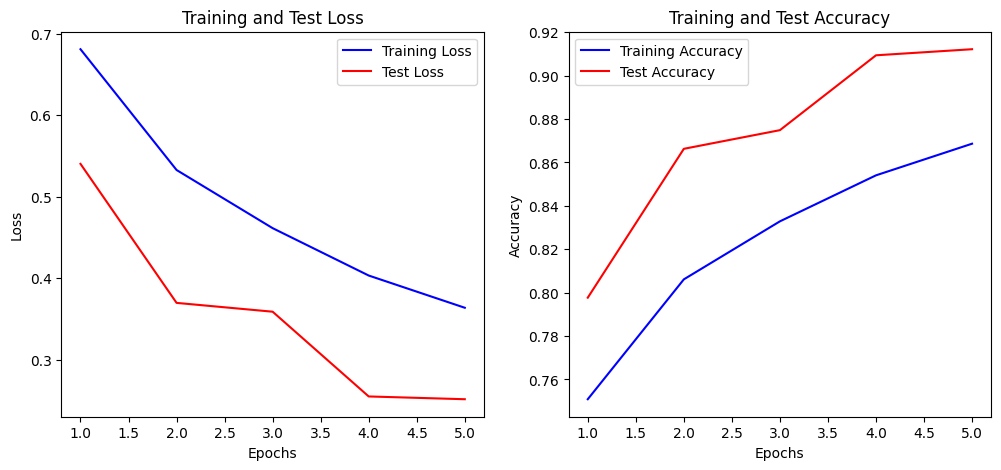

In [12]:
with mlflow.start_run() as run:

  model = FashionCNN()
  model.to(device)

  model = train_model(model,train_loader)